# Step 5: 전문가의 말을 쉽게 풀어 재구성된 text 생성
1. 세 closed llm을 활용해 multi-LLM 사용하기
2. rewrite시, 웹 검색하여 답변 보충하기

In [1]:
#api key
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
#!pip install -qU langchain-teddynote

In [3]:
#!pip install -U langchain-openai

In [4]:
#LangSmith 추적을 설정합니다. https://smith.langchain.com
from langchain_teddynote import logging

#프로젝트 이름을 입력합니다.
logging.langsmith("MEDICAL-LANGGRAPH")

LangSmith 추적을 시작합니다.
[프로젝트명]
MEDICAL-LANGGRAPH


* 1단계: 문서들을 전처리해서 VectorDB에 업로드하는 단계

In [5]:
#rag.pdf
from langchain import hub
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_upstage import UpstageEmbeddings
from langchain_upstage import ChatUpstage

from langchain_core.output_parsers import StrOutputParser
from abc import ABC, abstractmethod
from operator import itemgetter


class RetrievalChain(ABC):
    def __init__(self):
        self.source_uri = None
        self.k = 5

    @abstractmethod
    def load_documents(self, source_uris):
        """loader를 사용하여 문서를 로드합니다."""
        pass

    @abstractmethod
    def create_text_splitter(self):
        """text splitter를 생성합니다."""
        pass

    def split_documents(self, docs, text_splitter):
        """text splitter를 사용하여 문서를 분할합니다."""
        return text_splitter.split_documents(docs)

    def create_embedding(self):
        return UpstageEmbeddings(model="solar-embedding-1-large")

    def create_vectorstore(self, split_docs):
        return FAISS.from_documents(
            documents=split_docs, embedding=self.create_embedding()
        )

    def create_retriever(self, vectorstore):
        # MMR을 사용하여 검색을 수행하는 retriever를 생성합니다.
        dense_retriever = vectorstore.as_retriever(
            search_type="mmr", search_kwargs={"k": self.k}
        )
        return dense_retriever

    def create_model(self):
        return ChatUpstage(model_name="solar-llm", temperature=0)

    def create_prompt(self):
        return hub.pull("teddynote/rag-korean-with-source")

    @staticmethod
    def format_docs(docs):
        return "\n".join(docs)

    def create_chain(self):
        docs = self.load_documents(self.source_uri)
        text_splitter = self.create_text_splitter()
        split_docs = self.split_documents(docs, text_splitter)
        self.vectorstore = self.create_vectorstore(split_docs)
        self.retriever = self.create_retriever(self.vectorstore)
        model = self.create_model()
        prompt = self.create_prompt()
        self.chain = (
            {"question": itemgetter("question"), "context": itemgetter("context")}
            | prompt
            | model
            | StrOutputParser()
        )
        return self

In [6]:
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List


class PDFRetrievalChain(RetrievalChain):
    def __init__(self, source_uri):
        self.source_uri = source_uri
        self.k = 5

    def load_documents(self, source_uris: List[str]):
        docs = []
        for source_uri in source_uris:
            loader = PDFPlumberLoader(source_uri)
            docs.extend(loader.load())

        return docs

    def create_text_splitter(self):
        return RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

In [7]:
#load, spilt, embeding할 문서(pdf) 업로드
pdf = PDFRetrievalChain(["simplified_medical_report_summary.pdf"]).create_chain() #파일 이름 넣고 실행기기
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

# GraphState
각 노드에서 다음 노드로 전달되는 상태를 저장합니다.

In [8]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.documents import Document
from operator import add


#GraphState 상태를 저장하는 용도로 사용됩니다.
class GraphState(TypedDict):
    question: Annotated[str, add] #질문
    context: Annotated[str, add] #문서의 검색 결과
    answer: Annotated[str, add] #답변
    relevance: Annotated[str, add] #답변의 문서에 대한 관련성

# 노드와 엣지

주요 개념

* GraphState(상태 저장 그래프): 그래프의 각 노드가 계산의 단계를 나타냄
* Node(노드): 각 노드는 함수 또는 계산 단계를 나타냄 - 입력 처리, 의사 결정, 외부 API와의 상호작용 등 특정 작업을 수행하도록 노드 정의 가능
* Edge(엣지): 그래프에서 노드를 연결해 계산의 흐름을 정의. 조건부 엣지 또한 지원하므로 현재 상태에 따라 실행할 다음 노드를 동적으로 결정 가능

In [9]:
#rag.util
def format_docs(docs):
    return "\n".join(
        [
            f"<document><content>{doc.page_content}</content><source>{doc.metadata['source']}</source><page>{int(doc.metadata['page'])+1}</page></document>"
            for doc in docs
        ]
    )


# def format_searched_docs(docs):
#     return "\n".join(
#         [
#             f"<document><content>{doc['content']}</content><source>{doc['url']}</source></document>"
#             for doc in docs
#         ]
#     )
def format_searched_docs(docs):
    formatted_docs = []
    for doc in docs:
        if isinstance(doc, dict) and 'content' in doc and 'url' in doc:
            formatted_docs.append(f"<document><content>{doc['content']}</content><source>{doc['url']}</source></document>")
        else:
            formatted_docs.append("<document><content>Invalid document format</content><source>Unknown</source></document>")
    return "\n".join(formatted_docs)


def format_task(tasks):
    # 결과를 저장할 빈 리스트 생성
    task_time_pairs = []

    # 리스트를 순회하면서 각 항목을 처리
    for item in tasks:
        # 콜론(:) 기준으로 문자열을 분리
        task, time_str = item.rsplit(":", 1)
        # '시간' 문자열을 제거하고 정수로 변환
        time = int(time_str.replace("시간", "").strip())
        # 할 일과 시간을 튜플로 만들어 리스트에 추가
        task_time_pairs.append((task, time))

    # 결과 출력
    return task_time_pairs

In [10]:
from langchain_upstage import UpstageGroundednessCheck

#업스테이지 문서 관련성 체크 기능을 설정합니다. https://upstage.ai
upstage_ground_checker = UpstageGroundednessCheck()

#업스테이지 문서 관련성 체크를 실행합니다. 
upstage_ground_checker.run(
    {
        "context": format_docs(
            pdf_retriever.invoke("첫 번째 의사가 두 번째 의사를 선정할 때 유의해야할 사항은 무엇입니까?")
        ),
        "answer": "두 번째 의사 선정 시 유의해야 할 사항은 첫 번째 의사와 친밀한 관계자가 아니어야 한다는 점입니다.",
    }
)

'grounded'

노드 정의

In [11]:
#API 키 설정
import os

openai_api_key = os.getenv("OPENAI_API_KEY")
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
upstage_api_key = os.getenv("UPSTAGE_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_upstage import ChatUpstage
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from langchain_community.tools.tavily_search import TavilySearchResults
import tiktoken


#문서에서 검색하여 관련성 있는 문서를 찾는다.
def retrieve_document(state: GraphState) -> GraphState:
    #Question에 대한 문서 검색을 retriever로 수행합니다.
    retrieved_docs = pdf.retriever.invoke(state["question"])
    #검색된 문서를 형식화합니다.
    retrieved_docs = format_docs(retrieved_docs)
    #검색된 문서를 context 키에 저장합니다.
    return GraphState(question=state["question"], context=retrieved_docs, answer=state.get("answer", ""), relevance=state.get("relevance", ""))

prompt = ChatPromptTemplate.from_messages(
    [
            (
                "system",
                "You are a professional prompt rewriter. Your task is to generate the question in order to get additional information that is now shown in the context."
                "Your generated question will be searched on the web to find relevant information.",
            ),
            (
                "human",
                "Rewrite the question to get additional information to get the answer."
                "\n\nHere is the initial question:\n ------- \n{question}\n ------- \n"
                "\n\nHere is the initial context:\n ------- \n{context}\n ------- \n"
                "\n\nHere is the initial answer to the question:\n ------- \n{answer}\n ------- \n"
                "\n\nFormulate an improved question in Korean:",
            )
    ]
    )

#Chain을 사용해 답변을 생성합니다.
def llm_gpt_execute(state: GraphState) -> GraphState:
    #LLM 실행
    model = ChatOpenAI(api_key=openai_api_key, temperature=0, model="gpt-4o-mini", max_tokens=16384)
    chain = prompt | model | StrOutputParser()
    #체인을 호출하여 답변을 생성합니다.
    try:
        response = chain.invoke({question: state["question"], 
                                 context: state["context"],
                                 answer: state.get("answer", "No answer available yet.") #초기 상태에서 answer가 없을 경우를 대비
                                })
        return GraphState(answer=response, context=state["context"], question=state["question"])
    except Exception as e:
        print(f"Error in llm_gpt_execute: {str(e)}")
        error_message = f"Error occurred: {str(e)}"
        return GraphState(answer=error_message, context=state["context"], question=state["question"])

def llm_claude_execute(state: GraphState) -> GraphState:
    #LLM 실행
    model = ChatAnthropic(api_key=anthropic_api_key, temperature=0, model="claude-3-5-sonnet-20240620", max_tokens=4096)
    chain = prompt | model | StrOutputParser()
    #체인을 호출하여 답변을 생성합니다.
    try:
        response = chain.invoke({question: state["question"],
                                 context: state["context"],
                                 answer: state.get("answer", "No answer available yet.") #초기 상태에서 answer가 없을 경우를 대비
                                })
        return GraphState(answer=response, context=state["context"], question=state["question"])
    except Exception as e:
        print(f"Error in llm_gpt_execute: {str(e)}")
        error_message = f"Error occurred: {str(e)}"
        return GraphState(answer=error_message, context=state["context"], question=state["question"])

# def llm_solar_execute(state: GraphState) -> GraphState:
#     model = ChatUpstage(api_key=upstage_api_key, temperature=0, model="solar-1-mini-chat", max_tokens=10000) #최대 4096토큰까지 처리 가능
#     chain = prompt | model | StrOutputParser()
#     #체인을 호출하여 답변을 생성합니다.
#     try:
#         response = chain.invoke({
#             "question": state["question"], 
#             "context": state["context"],
#             "answer": state.get("answer", "No answer available yet.") #초기 상태에서 answer가 없을 경우를 비비
#         })
#         return GraphState(answer=response, context=state["context"], question=state["question"])
#     except Exception as e:
#         print(f"Error in llm_solar_execute: {str(e)}")
#         error_message = f"Error occurred: {str(e)}"
#         return GraphState(answer=error_message, context=state["context"], question=state["question"])

#best_llm_response의 헬퍼 함수: 각 LLM 함수를 병렬로 실행 -> 각 응답에 대해 별도로 관련성 확인 가능 => 가장 관련성이 높은 응답을 선택할 수 있도록 함
def process_query(state: GraphState, llm_func):
    result = llm_func(state) #각 LLM의 응답을 얻음
    relevance = upstage_ground_checker.run({"context": state["context"], "answer": result["answer"]}) #응답의 관련성을 평가함
    return result["answer"], relevance

#병렬로 multi_LLM을 실행하고, 이중 가장 관련성이 높은 응답을 택합니다.
def best_llm_response(state: GraphState) -> GraphState:
    try:
        with ThreadPoolExecutor(max_workers=2) as executor: #세 개의 LLM 함수를 병렬로 실행
            results = list(executor.map(partial(process_query, state), #process_query함수를 각 LLM함수에 적용 #각 LLM 함수가 동일한 state로 실행되고, 그 결과에 대해 관련성이 체크됨
                                        [llm_gpt_execute, llm_claude_execute]))
            best_response = max(results, key=lambda x: x[1])

            #토큰 수 제한
            max_answer_tokens = 4096
            answer = best_response[0]
            while num_tokens_from_string(answer) > max_answer_tokens:
                answer = answer[:len(answer)//2] #답변 길이 줄기
            #결과 중 가장 높은 관련성 점수를 가진 응답을 선택합니다. 
            return GraphState(answer=answer, context=state["context"], question=state["question"], relevance=best_response[1]) #가장 높은 relevance 점수를 가진 응답의 relevance를 사용
    except Exception as e:
        print(f"Error in best_llm_response: {e}")
        return GraphState(answer="Error occurred", context=state["context"], question=state["question"], relevance="확인불가")

#관련성 체크를 실행합니다.
def relevance_check(state: GraphState) -> GraphState:
    print("relevance_check", state)
    #관련성 체크 결과: grounded, notGrounded, notSure
    response = upstage_ground_checker.run({"context": state["context"], "answer": state["answer"]})
    return GraphState(relevance=response, context=state["context"], answer=state["answer"], question=state["question"])

#관련성 체크 결과를 반환합니다.
def is_relevant(state: GraphState) -> str:
    relevance = state["relevance"]
    if relevance == "grounded":
        return "관련성 O"
    elif relevance == "notGrounded":
        return "관련성 X"
    else:
        return "확인불가"

#notGrounded, notSure에 대해 재작성을 수행합니다.
def rewrite_query(state):
    # question = state["question"]
    # answer = state["answer"]
    # context = state["context"]
    new_state = llm_gpt_execute(state)
    return GraphState(question=new_state["answer"], context=state["context"], answer="", relevance="")

#notGrounded, notSure에 대해 웹 검색을 수행합니다.
# def search_on_web(state: GraphState) -> GraphState:
#     #문서에서 검색하여 관련성 있는 문서를 찾습니다.
#     search_tool = TavilySearchResults(max_results=5) #최대 5개의 결과를 반환하도록 설정
#     search_result = search_tool.invoke({"query": state["question"]}) #웹 검색 수행
#     #검색된 문서를 형식화합니다.
#     search_result = format_searched_docs(search_result)
#     #검색된 문서를 context 키에 저장합니다.
#     return GraphState(question=state["question"], context=search_result, answer=state.get("answer", ""), relevance=state.get("relevance", "")) #GraphState 객체를 생성하여 반환

#웹 검색 결과가 str이 아닌, 문자열을 반환한다면. 
def search_on_web(state: GraphState) -> GraphState: # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    try:
        # 현재 컨텍스트의 토큰 수 계산
        current_tokens = num_tokens_from_string(state["question"] + state.get("context", "") + state.get("answer", ""))
        
        search_tool = TavilySearchResults(api_key=tavily_api_key, max_results=5)
        search_result = search_tool.invoke({"query": state["question"]})
        
        formatted_result = format_searched_docs(search_result)
        
        # 전체 토큰 수 제한 (예: 모델 최대 토큰의 90%)
        max_total_tokens = int(32768 * 0.9)  
        max_search_tokens = max_total_tokens - current_tokens

        while num_tokens_from_string(formatted_result) > max_search_tokens:
            search_result = search_result[:-1]
            formatted_result = format_searched_docs(search_result)
        
        new_context = state.get("context", "") + "\n" + formatted_result
        return GraphState(question=state["question"], context=new_context, answer=state.get("answer", ""), relevance=state.get("relevance", ""))
    except Exception as e:
        error_message = f"Error in web search: {str(e)}"
        return GraphState(question=state["question"], context=error_message, answer="", relevance="")
        
    #     # search_result의 형식 확인 및 처리
    #     if isinstance(search_result, list):
    #         # 검색된 문서를 형식화합니다.
    #         formatted_result = format_searched_docs(search_result)
    #     elif isinstance(search_result, str):
    #         # 결과가 문자열인 경우 (오류 메시지일 가능성)
    #         formatted_result = f"<document><content>{search_result}</content><source>Web search</source></document>"
    #     else:
    #         # 예상치 못한 형식의 경우
    #         formatted_result = "<document><content>Unexpected search result format</content><source>Web search</source></document>"
        
    #     # 검색된 문서를 context 키에 저장합니다.
    #     return GraphState(question=state["question"], context=formatted_result, answer=state.get("answer", ""), relevance=state.get("relevance", ""))
    # except Exception as e:
    #     error_message = f"Error in web search: {str(e)}"
    #     return GraphState(question=state["question"], context=error_message, answer="", relevance="")

In [15]:
# best_llm_response
#     |
#     |-- ThreadPoolExecutor
#         |
#         |-- process_query(llm_gpt_execute)
#         |       |-- llm_gpt_execute 실행
#         |       |-- 결과에 대한 관련성 체크
#         |
#         |-- process_query(llm_claude_execute)
#         |       |-- llm_claude_execute 실행
#         |       |-- 결과에 대한 관련성 체크
#         |
#         |-- process_query(llm_solar_execute)
#                 |-- llm_solar_execute 실행
#                 |-- 결과에 대한 관련성 체크
#     |
#     |-- 가장 관련성 높은 결과 선택

# 그래프 정의

In [17]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

#(1): Conventional RAG
#(2): 재검색
#(3): 멀티 LLM
#(4): 쿼리 재작성

#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

#노드를 추가합니다. #("노드명", 함수명)
workflow.add_node("retrieve", retrieve_document)

workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("Claude 요청", llm_claude_execute)
#workflow.add_node("Solar 요청", llm_solar_execute) #(3)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Claude_relevance_check", relevance_check)
#workflow.add_node("Solar_relevance_check", relevance_check) #(3)
workflow.add_node("결과 종합", best_llm_response)

workflow.add_node("rewrite", rewrite_query)
workflow.add_node("search_on_web", search_on_web)

#각 노드들을 연결합니다
workflow.add_edge("retrieve", "GPT 요청")
workflow.add_edge("retrieve", "Claude 요청")
#workflow.add_edge("retrieve", "Solar 요청") #(3)
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")
workflow.add_edge("Claude 요청", "Claude_relevance_check")
workflow.add_edge("Claude_relevance_check", "결과 종합")
#workflow.add_edge("Solar 요청", "Solar_relevance_check") #(3)
#workflow.add_edge("Solar_relevance_check", "결과 종합") #(3)
workflow.add_edge("rewrite", "search_on_web") #(4)
workflow.add_edge("search_on_web", "retrieve")#(4)

#조건부 엣지를 추가합니다. #(4)
workflow.add_conditional_edges(
    "결과 종합", #관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "관련성 O": END,  # 관련성이 있으면 종료합니다.
        "관련성 X": "rewrite",  # 관련성이 없으면 다시 답변을 생성합니다.
        "확인불가": "rewrite",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    }
)

#시작 노드 설정
workflow.set_entry_point("retrieve")

#MemorySaver 객체 생성
memory = MemorySaver()

#그래프 컴파일
app = workflow.compile(checkpointer=memory)

# 그래프 시각화

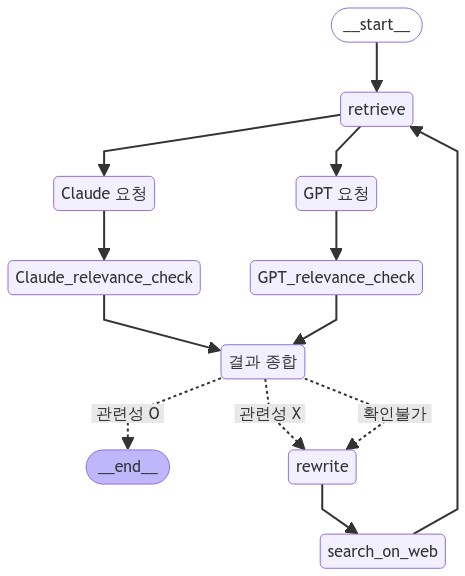

In [18]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [19]:
from langchain.schema.runnable import RunnableConfig
from langgraph.errors import GraphRecursionError

#코드의 흐름을 더 명확하게 만들고, 필요한 경우 입력 데이터를 쉽게 수정할 수 있도록 함. 
inputs = GraphState(
    question="첫 번째 의사가 두 번째 의사를 선정할 때 유의해야할 사항은 무엇입니까?",
    context="",
    answer="",
    relevance=""
)

In [20]:
import pprint 
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=12, configurable={"thread_id": "CORRECTIVE-RAG"})

#GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="첫 번째 의사가 두 번째 의사를 선정할 때 유의해야할 사항은 무엇입니까?")

#app.stream을 통해 입력된 메세지에 대한 출력을 스트리밍합니다.
try:
    final_output = None
    for output in app.stream(inputs, config=config):
        final_output = output
        #출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            #노드의 이름과 해당 노드에서 나온 출력을 출력합니다. 
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            #출력 값을 예쁘게 출력합니다. 
            pprint.pprint(value, indent=2, width=80, depth=None)
        #각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

"Output from node 'retrieve':"
'---'
{ 'answer': '',
  'context': '<document><content>환자의 보험은 2차 소견을 구하는 특정한 보험을 사용합니다. 환자는 주치의에게 '
             '다른 의사가 전문의의 추천을 요청할 수 있습니다. 의사들은 대부분 다른 의견을 환영하며, 두 번째 의사는 첫 번째 '
             '의사와 동일한 의견을 가지지 않을 수 있습니다. 환자는 첫 번째 의사와 동일한 의견을 가지지 않는 두 번째 의사를 '
             '선임할 수 있으며, 대학병원, 전문의료협회, 또는 보험회사에서 선임할 수 있습니다. 환자는 두 번째 의사를 선임할 '
             '수 없는 경우, 다른 방법을 찾아야 합니다. 구체적인 치료 계획은 환자의 상태와 의사의 판단에 따라 '
             '달라집니다.</content><source>simplified_medical_report_summary.pdf</source><page>1</page></document>',
  'question': '첫 번째 의사가 두 번째 의사를 선정할 때 유의해야할 사항은 무엇입니까?',
  'relevance': ''}
'\n---\n'
Error in llm_gpt_execute: name 'question' is not defined
"Output from node 'GPT 요청':"
'---'
{ 'answer': "Error occurred: name 'question' is not defined",
  'context': '<document><content>환자의 보험은 2차 소견을 구하는 특정한 보험을 사용합니다. 환자는 주치의에게 '
             '다른 의사가 전문의의 추천을 요청할 수 있습니다. 의사들은 대부분 다른 의견을 환영하며, 두 번째 의사는 첫 번째 '
             '의사와 동일한 의견을 가지지 않을 수 있습니다. 환자는

In [21]:
if final_output and "결과 종합" in final_output:
    print("Question: \t", output["결과 종합"]["question"])
    print("Answer: \t", output["결과 종합"]["answer"])
    print("Relevance: \t", output["결과 종합"]["relevance"])
else:
    print("No final output or '결과 종합' key not found in the output.")

No final output or '결과 종합' key not found in the output.


## LangSmith 추적

- 추적: https://smith.langchain.com/public/ce7b4ea8-df34-4bb6-850e-afc8d12e75e6/r